In [136]:
using Pkg
Pkg.activate("/home/fedflorio/master_thesis")

  Activating project at `~/master_thesis`


In [137]:
using MatrixProductBP, MatrixProductBP.Models
using TensorTrains, LogarithmicNumbers
using Graphs, IndexedGraphs, SparseArrays
using Random, Statistics
using Plots, LaTeXStrings
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

In [138]:
using Revise
includet("/home/fedflorio/master_thesis/MatrixProductBP.jl/notebooks/glauber_continuous/GMPS.jl")

In [139]:
T = 7
N = 5
k = 2
maxJ = 5
K = 2*maxJ + 1
seed = 0
separation = 2
nsnaps = 3

rng = MersenneTwister(seed)
A = [0 1 1 0 1;
     1 0 0 1 0;
     1 0 0 1 0;
     0 1 1 0 1;
     1 0 0 1 0]
A = sparse(A)
# gg = random_regular_graph(N, k; seed)
# gg = prufer_decode(rand(rng, 1:N, N-2))
# gg = path_graph(N)

# A = adjacency_matrix(gg)
rand!(rng, A.nzval, (-maxJ:maxJ))  # fill directed incidence matrix with rand(-1,1)
g = IndexedBiDiGraph(A)
β = 0.2
h = 0.5

w = [fill(MatrixProductBP.Models.IntegerGlauberFactor([A[j,i] for j in inneighbors(g,i)], h, β), T+1) for i in vertices(g)]
# w = [fill(GenericGlauberFactor([A[j,i] for j in inneighbors(g,i)]*J, h, β), T+1) for i in vertices(g)]
bp = mpbp(g, w, fill(2,N), T);

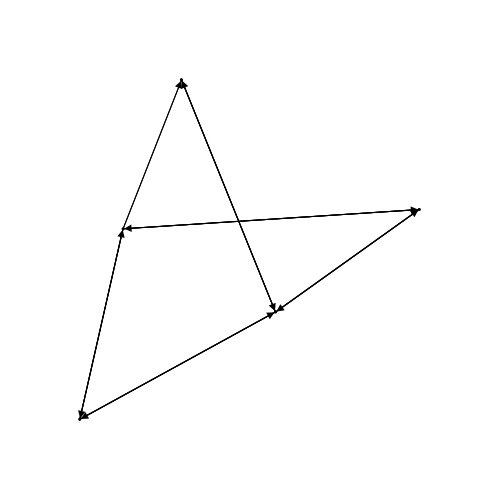

In [140]:
using GraphRecipes
graphplot(SimpleDiGraph(A), curves=false, size=(500,500), nodeshape=:circle,
    nodecolor=:black, nodesize=0.01, arrow=arrow(:closed, 0.1))

In [141]:
obs_times = collect(range(separation, step=separation, length=nsnaps))
nobs = floor(Int, N * length(obs_times) * 1.0)
obs_fraction = nobs / N
rng = MersenneTwister(seed)
X, observed = draw_node_observations!(bp, nobs, times = obs_times .+ 1, softinf=Inf; rng);

In [142]:
reset!(bp)
# spin(x, i) = 3-2x
# spin(x) = spin(x, 0)
cb = CB_BP(bp);

In [143]:
svd_trunc = TruncBond(4)
iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-4, damp=0.2);

Running MPBP: iter 12    Time: 0:00:03
  Δ:                7.978937817165743e-5


In [144]:
b = bp.b[1]
bGauss = GMPS(b)

GaussianTensorTrain{Float64, 2}([[[-0.8074591310877897 0.9492227658898378], [-0.7066108425761528 -0.1605011610391483 -0.9365813450648669 -0.38829111011712736; 0.647763731145976 -0.9244848419375827 -0.11682335282572104 -0.5148750698321352], [-0.8119982078493431 0.32776057852874774 … 0.0 0.0; 0.3214617489756521 0.6439494129802624 … 0.0 0.0; 0.11703710152168544 0.5042888875122518 … 0.0 -0.8811963764282629; -0.011429133504916138 -0.010095961907209306 … 0.8811963764282629 0.0], [-0.8818677520877564 -0.744781058384589 … 2.3172790958278435e-10 6.587286425428223e-9; 0.039006062420736495 -0.4426928394531501 … 1.3598913603164018e-9 3.8971804400506635e-8; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.8777453360161609 -0.02223781151863836 … -0.0007774959820775066 -5.754892742270939e-6; -0.07479953596476767 -0.4766053732096659 … -0.013364197723891212 0.00019396837158734071; … ; -1.0556310977228692e-12 1.5755531343818755e-12 … 1.4082560789523546e-9 -1.3833133959936152e-8; -1.9732934053715167e-13 -1.

In [145]:
b_reconstruct = reconstruct_GMPS(bGauss)

TensorTrain{Float64, 3}([[-0.5426825936908962 0.0014679458914561194;;; -255.75816635548537 0.6918208799630856], [-0.0008785969295144846 -0.026882435454503688 -0.31520758766102325 -0.1348027358323813; 0.0047876721293416535 -0.21889053209433715 -0.0147564249599034 -0.17512518064109547;;; -0.5239741392009237 -0.017891791599974217 -0.1396338061321013 -0.9452549152240955; 0.4073967041236249 -0.22850601783242552 -0.010686673556980997 -1.1529994285956104], [NaN NaN … 0.0 0.0; NaN NaN … 0.0 0.0; NaN NaN … 0.0 NaN; NaN NaN … NaN 0.0;;; NaN NaN … 0.0 0.0; NaN NaN … 0.0 0.0; NaN NaN … 0.0 NaN; NaN NaN … NaN 0.0], [-3.523846456578358 -2.385163513694274e-6 … 2.0540460595967968e-11 2.408617424089626e-24; 0.014114785599490056 -0.22899314283334443 … 1.1979546381246123e-10 1.3120998751558136e-23; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -4.204389007813851e-87 -0.7629031127615292 … 2.8037742939067078e-11 1.1239288630827819e-8; 0.1133101319138234 -10.534148120133993 … 1.631589380285664e-10 6.657004864

In [146]:
marg_bp = marginals(b)
display(marg_bp)
p_bp = [bᵗ[1] for bᵗ in marg_bp]

marg_Gauss = marginals(b_reconstruct)
display(marg_Gauss)
p_Gauss = [bᵗ[1] for bᵗ in marg_Gauss]
;

8-element Vector{Vector{Float64}}:
 [0.4629536142655335, 0.5370463857344666]
 [0.1792950601130279, 0.8207049398869722]
 [1.0, 4.180847061324406e-18]
 [0.9516538796995835, 0.04834612030041651]
 [1.3834796953118829e-16, 0.9999999999999999]
 [0.010618831603757092, 0.9893811683962429]
 [-1.6606536923884226e-17, 1.0]
 [0.7310585788640068, 0.26894142113599306]

8-element Vector{Vector{Float64}}:
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]
 [NaN, NaN]

In [149]:
t=3
display(b[t])
display(b_reconstruct[t])
println("\n\n")
display(bGauss[1][t])
display(bGauss[2][t])
display(bGauss[3][t])
;

4×8×2 Array{Float64, 3}:
[:, :, 1] =
 -0.811998    0.327761  -0.0943166  -0.0290405  …  -1.97873e-18  0.0  0.0
  0.321462    0.643949  -0.497548   -0.104616      -7.12824e-18  0.0  0.0
  0.117037    0.504289   0.692622    0.169639       1.15587e-17  0.0  0.0
 -0.0114291  -0.010096  -0.20083     0.857871       5.84527e-17  0.0  0.0

[:, :, 2] =
 0.0  0.0  7.48958e-16  -5.97e-12  …   2.59967e-11  0.0        0.0
 0.0  0.0  0.0           0.0          -0.881196     0.0        0.0
 0.0  0.0  0.0           0.0           0.0          0.0       -0.881196
 0.0  0.0  0.0           0.0           0.0          0.881196   0.0

4×8×2 Array{Float64, 3}:
[:, :, 1] =
 NaN  NaN   -2.11046e5  -404.016  -Inf           Inf    0.0    0.0
 NaN  NaN  NaN           NaN       -0.00276238  NaN     0.0    0.0
 NaN  NaN  NaN           NaN      NaN           NaN     0.0  NaN
 NaN  NaN  NaN           NaN      NaN           NaN   NaN      0.0

[:, :, 2] =
 NaN  NaN  -Inf   -0.0   -3.72006e5      1.87959e-8    0.0    0.0
 NaN  NaN  NaN   NaN     -3.01313e-11  NaN             0.0    0.0
 NaN  NaN  NaN   NaN    NaN            NaN             0.0  NaN
 NaN  NaN  NaN   NaN    NaN            NaN           NaN      0.0

4×8 Matrix{Float64}:
 -0.811998    0.327761  -0.0943166  …   2.59967e-11  0.0        0.0
  0.321462    0.643949  -0.497548      -0.881196     0.0        0.0
  0.117037    0.504289   0.692622       1.15587e-17  0.0       -0.881196
 -0.0114291  -0.010096  -0.20083        5.84527e-17  0.881196   0.0

4×8 Matrix{Float64}:
 -0.811998    0.327761  -0.0943166  …  -2.59967e-11   0.0       0.0
  0.321462    0.643949  -0.497548       0.881196      0.0       0.0
  0.117037    0.504289   0.692622       1.15587e-17   0.0       0.881196
 -0.0114291  -0.010096  -0.20083        5.84527e-17  -0.881196  0.0

4×8 Matrix{Float64}:
 -0.811998    0.327761  -0.0943166  …   2.59967e-11  0.0        0.0
  0.321462    0.643949  -0.497548      -0.881196     0.0        0.0
  0.117037    0.504289   0.692622       1.15587e-17  0.0       -0.881196
 -0.0114291  -0.010096  -0.20083        5.84527e-17  0.881196   0.0